# Machine Learning Basics: Predicting Kubernetes Incidents - Part 2

## 7. Loading the Preprocessed Dataset

We’ll use the provided dataset to predict Kubernetes incidents (`event_type`) based on metrics such as CPU allocation efficiency, memory allocation efficiency, and other operational data.

### Dataset Columns:
1. **Features**:
   - `cpu_allocation_efficiency`, `memory_allocation_efficiency`
   - `disk_io`, `network_latency`, `node_temperature`, `node_cpu_usage`, `node_memory_usage`
   - Derived features: `resource_efficiency`, `io_latency_ratio`, etc.
2. **Target**:
   - `event_type`: Indicates the type of incident (`Normal`, `Warning`, or `Error`).
3. **Other Columns**:
   - Metadata like `timestamp`, `namespace`, and `pod_name`.
   - These may not directly contribute to prediction and will be excluded.

In [42]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
)
from sklearn.preprocessing import label_binarize, StandardScaler
from ipywidgets import interact

# Load the dataset
df = pd.read_csv("data/preprocessed_kubernetes_data.csv")

# Display the first few rows to understand the structure
df.head()

,timestamp,pod_name,namespace,cpu_allocation_efficiency,memory_allocation_efficiency,disk_io,network_latency,node_temperature,node_cpu_usage,node_memory_usage,event_type,event_message,scaling_event,pod_lifetime_seconds,hour,day_of_week,resource_efficiency,io_latency_ratio
0,2023-01-01 00:00:00,pod_0,dev,0.038162,0.949259,10.770664,13.722542,77.619073,93.177619,37.900532,Warning,Killed,False,119648.0,0,6,0.493711,0.678794
1,2023-01-01 00:00:00,pod_1,default,0.500763,0.048543,935.792442,55.493953,84.182245,61.442289,5.208161,Error,Failed,True,144516.0,0,6,0.274653,16.564471
2,2023-01-01 00:00:00,pod_2,kube-system,0.746726,0.447345,328.352359,173.910016,21.295244,55.819311,18.335802,Normal,Completed,True,68857.0,0,6,0.597035,1.877264
3,2023-01-01 00:00:00,pod_3,default,0.526692,0.870251,778.297708,67.395729,85.028829,78.968463,94.619689,Warning,OOMKilled,True,72080.0,0,6,0.698472,11.379332
4,2023-01-01 00:00:00,pod_4,prod,0.425342,0.885459,711.181295,91.724730,29.157695,52.718141,70.770594,Error,Killed,False,123016.0,0,6,0.655401,7.669813


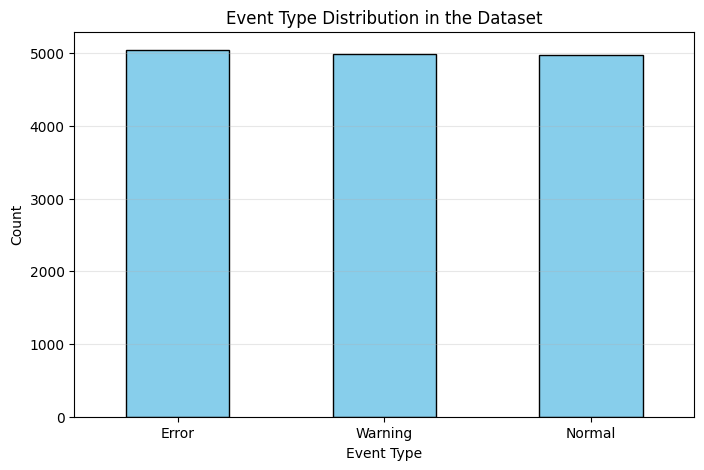

In [43]:
# Count the occurrences of each event type in the dataset
event_counts = df["event_type"].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 5))
event_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Event Type Distribution in the Dataset")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.show()

## 8. Data Preprocessing

In [44]:
# Scale the numerical features to improve model performance
scaler = StandardScaler()
numerical_features = [
    "cpu_allocation_efficiency",
    "memory_allocation_efficiency",
    "disk_io",
    "network_latency",
    "node_temperature",
    "node_cpu_usage",
    "node_memory_usage",
    "resource_efficiency",
    "io_latency_ratio",
]
df[numerical_features] = scaler.fit_transform(df[numerical_features])

## 9. Selecting Features and Target Variable

From the dataset, we’ll:
1. Use only numerical columns for prediction (e.g., CPU and memory metrics).
2. Drop unnecessary metadata such as `timestamp`, `pod_name`, and `namespace`.

### Target Variable:
- The column `event_type` contains the incident labels (`Normal`, `Warning`, or `Error`).

In [45]:
# Select numerical features and use `event_type` as the target variable
X = df[numerical_features]
y = df["event_type"]

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Display Dataset Shapes
print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")

Training Set: (10500, 9), Testing Set: (4500, 9)


## 10. Splitting the Data: Training and Testing Sets

To evaluate the model, we’ll split the data into:
- **Training Set (70%)**: Used to train the model.
- **Testing Set (30%)**: Used to evaluate its performance.

This ensures the model is trained and tested on different data, avoiding overfitting.

In [46]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Display sizes of the training and testing sets
print(f"Training Set Size: {X_train.shape[0]}")
print(f"Testing Set Size: {X_test.shape[0]}")

Training Set Size: 10500
Testing Set Size: 4500


## 11. Training a Random Forest Classifier

A **Random Forest Classifier** is an ensemble method that trains multiple decision trees and combines their outputs to improve accuracy and reduce overfitting. 

In [47]:
# Random Forests are robust models that can handle structured data efficiently.
rf_model = RandomForestClassifier(random_state=42, max_depth=10, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

## 12. Evaluating the Model

In [48]:
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.33

Classification Report:
              precision    recall  f1-score   support

       Error       0.34      0.45      0.39      1521
      Normal       0.34      0.24      0.28      1517
     Warning       0.31      0.29      0.30      1462

    accuracy                           0.33      4500
   macro avg       0.33      0.33      0.33      4500
weighted avg       0.33      0.33      0.33      4500



The following code cell helps visualize the Actual vs. Predicted Labels for a subset of the test dataset. This visualization enables us to analyze where the model is making correct or incorrect predictions.

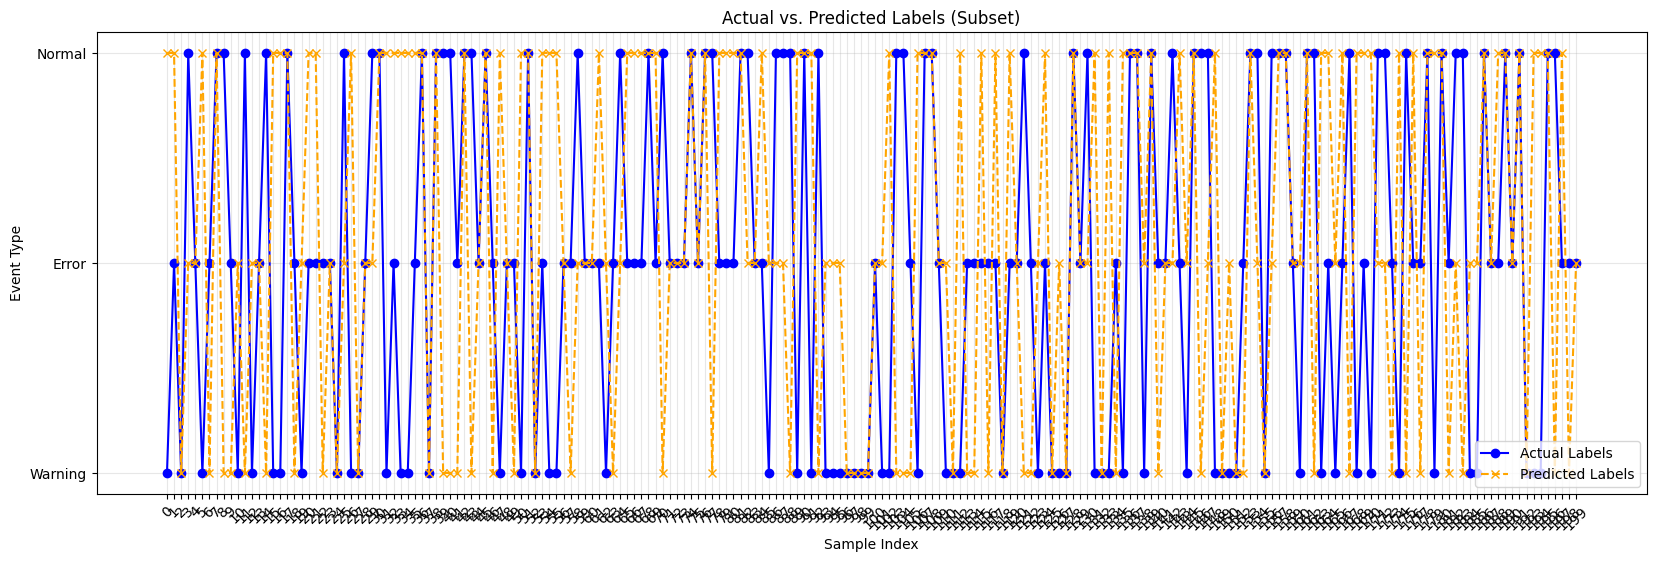

In [49]:
# Create a DataFrame for comparison
results_df = pd.DataFrame(
    {
        "Actual": y_test.values,
        "Predicted": y_pred,
    }
).reset_index(drop=True)

# Create a subset for visualization (e.g., first 50 samples)
subset = results_df.iloc[:200]

# Reset the index for clarity
subset = subset.reset_index()

# Plot actual vs. predicted labels for the subset
plt.figure(figsize=(20, 6))
plt.plot(
    subset.index,
    subset["Actual"],
    label="Actual Labels",
    marker="o",
    linestyle="-",
    color="blue",
)
plt.plot(
    subset.index,
    subset["Predicted"],
    label="Predicted Labels",
    marker="x",
    linestyle="--",
    color="orange",
)
plt.title("Actual vs. Predicted Labels (Subset)")
plt.xlabel("Sample Index")
plt.ylabel("Event Type")
plt.xticks(subset.index, labels=subset.index, rotation=45)
plt.yticks(range(len(y.unique())), labels=y.unique())
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Confusion Matrix

The confusion matrix visualizes the model’s performance by comparing:
- Actual labels (`y_test`) and predicted labels (`y_pred`).

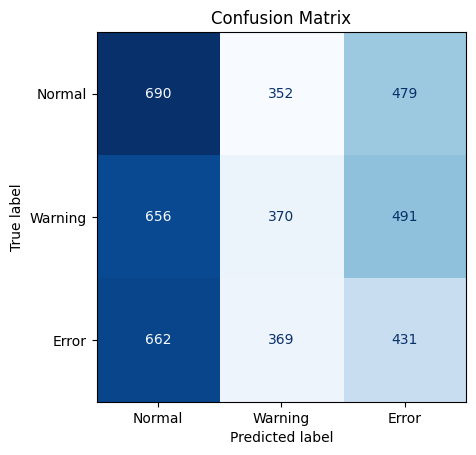

In [50]:
ConfusionMatrixDisplay.from_estimator(
    rf_model,
    X_test,
    y_test,
    display_labels=["Normal", "Warning", "Error"],
    cmap="Blues",
    colorbar=False,
)
plt.title("Confusion Matrix")
plt.show()

### ROC Curve: Visualizing Classifier Performance

The **ROC Curve (Receiver Operating Characteristic)** evaluates the trade-off between the **True Positive Rate (TPR)** and **False Positive Rate (FPR)** for a binary classification model. It shows how well the model separates the positive and negative classes across different thresholds.

#### AUC (Area Under the Curve):
- The **AUC** represents the model’s ability to distinguish between classes.
- A perfect model has an AUC of **1.0**, while a random classifier has an AUC of **0.5**.

#### Key Terms:
1. **True Positive Rate (TPR)**: Sensitivity or recall.
   - Formula: `TPR = TP / (TP + FN)`
2. **False Positive Rate (FPR)**: Probability of falsely classifying negatives as positives.
   - Formula: `FPR = FP / (FP + TN)`

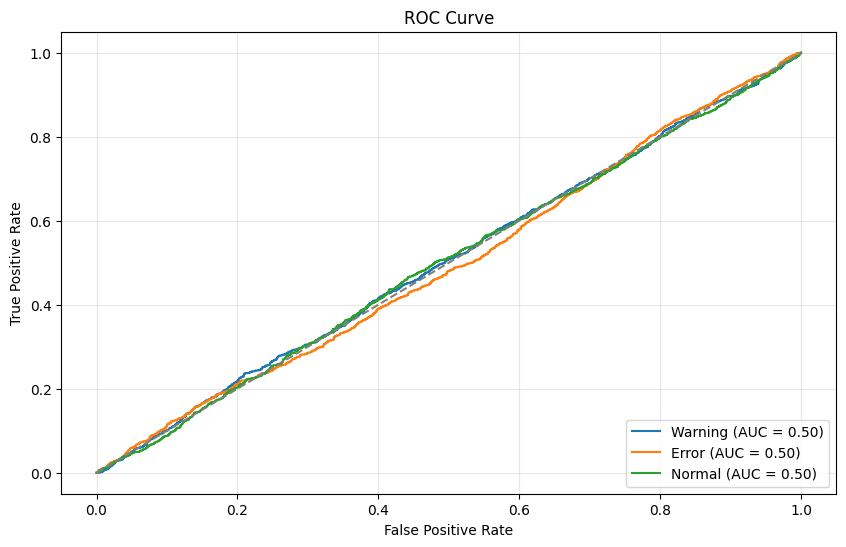

In [51]:
# Binarize target labels
y_test_binary = label_binarize(y_test, classes=y.unique())
y_prob = rf_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 6))
for i, class_label in enumerate(y.unique()):
    fpr, tpr, _ = roc_curve(y_test_binary[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## 13. Feature Importance

Understanding which features contribute most to the model’s predictions helps us:
- Identify critical metrics for operational health.
- Interpret the model’s decisions for real-world scenarios.

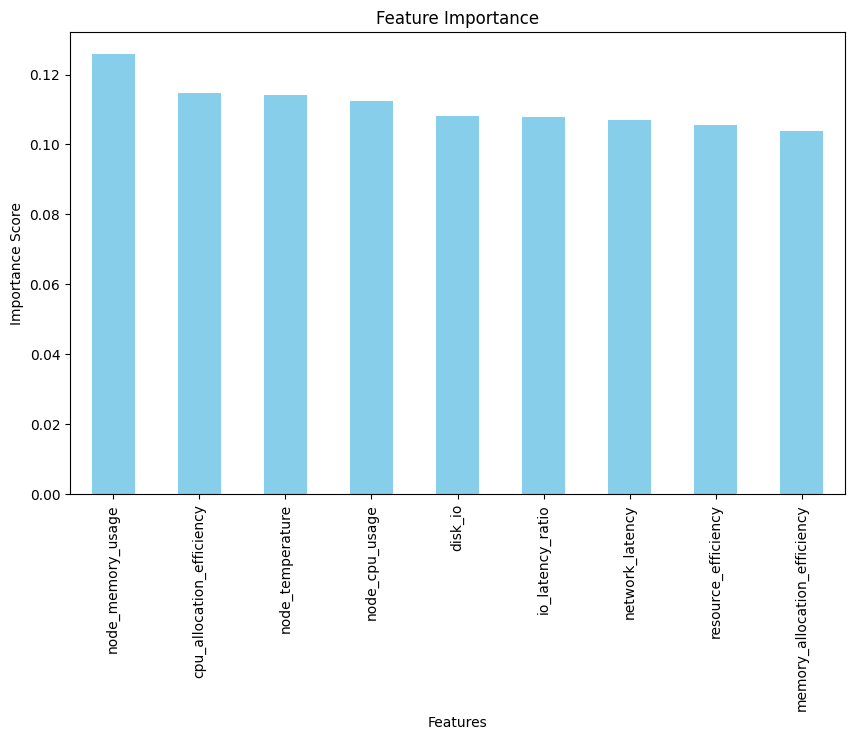

In [52]:
# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind="bar", color="skyblue")
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

## 14. Interactivity: Tune Model Parameters

Use the sliders below to adjust the model’s parameters (e.g., tree depth) and observe how it affects performance.

In [53]:
from ipywidgets import interact


# Interactive function to train and evaluate the model
def train_rf(max_depth, n_estimators):
    rf_model = RandomForestClassifier(
        random_state=42, max_depth=max_depth, n_estimators=n_estimators
    )
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


# Create sliders for parameters
interact(train_rf, max_depth=(2, 20, 1), n_estimators=(10, 200, 10))

interactive(children=(IntSlider(value=11, description='max_depth', max=20, min=2), IntSlider(value=100, descri…

<function __main__.train_rf(max_depth, n_estimators)>

## Conclusion

In this notebook, we introduced the basics of machine learning and trained a Random Forest Classifier to predict Kubernetes incidents. Key takeaways:
- **Supervised Learning**: Learn patterns from labeled data.
- **Random Forest**: A robust and interpretable model.
- **Feature Importance**: Insights into key metrics influencing predictions.

### What’s Next:
In the next notebook, we’ll explore more advanced techniques, including:
1. **Deep Learning**: Using LSTM/Transformers for time-series data.
2. **Generative AI**: Suggesting remediation actions based on incidents.